# 📊 Analyse des Vulnérabilités de Sécurité


---

## 📚 Table des Matières
1. Configuration
2. Distribution des Niveaux de Gravité
3. Types de Vulnérabilités (CWE)
4. Analyse des Scores EPSS
5. Éditeurs les Plus Touchés
6. Relation entre Sévérité et Probabilité d'Exploitation (EPSS)
7. Corrélation CVSS-EPSS
8. Dispersion des CVSS dans le Temps
9. Dispersion des Scores CVSS par Éditeur
10. Dispersion des CVSS par Version de Produit
11. Analyse par Type de Bulletin
12. Focus sur le CWE Principal




---

## 🔧 1. Configuration

*Import des bibliothèques nécessaires et configuration de l'environnement d'analyse*

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

FIGURE_SIZE = (12, 8)
SEVERITY_CONFIG = {
    'bins': [0, 4, 7, 9, 10],
    'labels': ['Low', 'Medium', 'High', 'Critical'],
    'colors': ['green', 'yellow', 'orange', 'red']
}
EPSS_CONFIG = {
    'bins': [0, 0.001, 0.01, 0.1, 1.0],
    'labels': ['Très faible', 'Faible', 'Modéré', 'Élevé']
}


data = pd.read_csv('alerte_avis.csv')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

def process_scores(df):
    df_scores = df.copy()
    
    mask_cvss = df_scores['CVSS_Score'].notna()
    df_scores.loc[mask_cvss, 'Severity'] = pd.cut(
        df_scores.loc[mask_cvss, 'CVSS_Score'],
        bins=SEVERITY_CONFIG['bins'],
        labels=SEVERITY_CONFIG['labels'],
        include_lowest=True
    )
    
    mask_epss = df_scores['EPSS_Score'] != 'Non Dispo'
    df_scores.loc[mask_epss, 'EPSS_Score'] = df_scores.loc[mask_epss, 'EPSS_Score'].astype(float)
    df_scores.loc[mask_epss, 'EPSS_Category'] = pd.cut(
        df_scores.loc[mask_epss, 'EPSS_Score'],
        bins=EPSS_CONFIG['bins'],
        labels=EPSS_CONFIG['labels'],
        duplicates='drop'
    )
    
    return df_scores, mask_epss

def prepare_data(df):
    processed_data, mask_epss = process_scores(df)
    
    stats = {
        'severity_counts': processed_data['Severity'].value_counts().sort_index(),
        'epss_stats': processed_data[mask_epss]['EPSS_Score'].agg({
            'Max': 'max',
            'Moyenne': 'mean',
            'Médiane': 'median'
        }),
        'date_cumsum': df['Date'].value_counts().sort_index().cumsum()
    }
    
    cwe_valid = df['CWE'].dropna()[df['CWE'] != 'Non disponible']
    cwe_series = cwe_valid.str.extract(r'(\d+)')[0].value_counts()
    stats['cwe_counts'] = pd.concat([
        cwe_series.head(15),
        pd.Series({'Autres': cwe_series[15:].sum()})
    ])
    
    vendors_series = df['Éditeur'].dropna().value_counts()
    top_vendors = vendors_series.head(10)
    stats['vendors_counts'] = pd.concat([
        top_vendors,
        pd.Series({'Autres': vendors_series[10:].sum()})
    ])
    
    stats['correlation'] = {
        'contingency': pd.crosstab(
            processed_data.loc[mask_epss, 'Severity'],
            processed_data.loc[mask_epss, 'EPSS_Category'],
            normalize='index'
        ),
        'means': processed_data[mask_epss].groupby('Severity', observed=True)['EPSS_Score'].mean().round(3)
    }
    
    version_series = df['Versions'].dropna().str.extract(r'(\d+\.\d+)')[0].value_counts()
    stats['versions'] = {
        'counts': pd.concat([
            version_series.head(10),
            pd.Series({'Autres': version_series[10:].sum()})
        ]),
        'products': {
            version: (df[df['Versions'].str.contains(version, na=False)]['Produit'].mode()[0]
                     if version != 'Autres' else 'Divers')
            for version in version_series.head(10).index
        }
    }
    stats['versions']['products']['Autres'] = 'Divers'
    
    stats['boxplot_data'] = processed_data[
        processed_data['Éditeur'].isin(top_vendors.index)
    ]
    
    bulletin_data = df.dropna(subset=['Éditeur', 'Type'])
    stats['bulletin_data'] = bulletin_data.groupby(
        ['Éditeur', 'Type']
    ).size().unstack(fill_value=0).loc[top_vendors.index]
    
    return processed_data, stats

processed_data, stats = prepare_data(data)


---

## 📈 2. Analyse de la Distribution des Niveaux de Gravité

*Catégories de gravité CVSS (Système commun de notation des vulnérabilités)* :

Figure(1200x800)


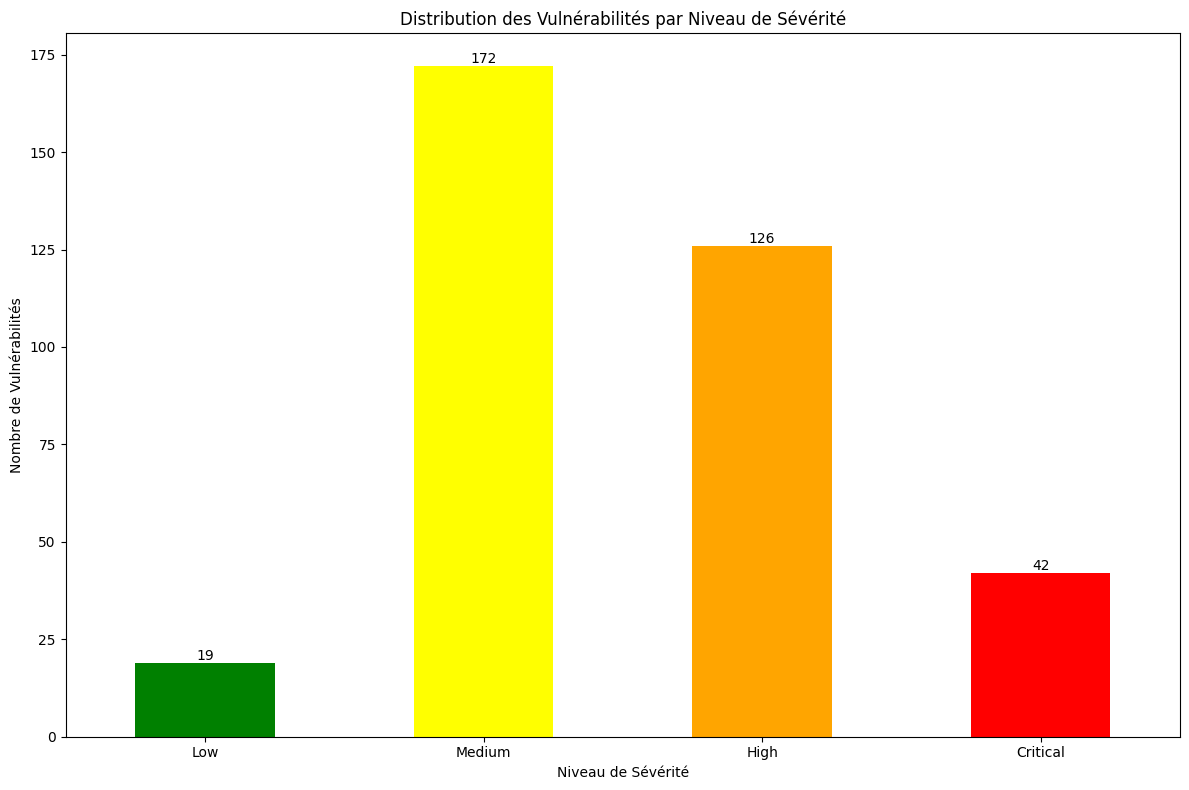

In [50]:
def plot_severity_distribution():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    bars = stats['severity_counts'].plot(
        kind='bar',
        color=SEVERITY_CONFIG['colors'],
        ax=ax
    )
    
    for bar in bars.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom'
        )
    
    ax.set_title('Distribution des Vulnérabilités par Niveau de Sévérité')
    ax.set_xlabel('Niveau de Sévérité')
    ax.set_ylabel('Nombre de Vulnérabilités')
    ax.tick_params(axis='x', rotation=0)
    plt.tight_layout()
    
    return fig
print(plot_severity_distribution())

---

## 🎯 3. Types de Vulnérabilités (CWE)

*Analyse des Common Weakness Enumeration (CWE) les plus fréquentes*


Figure(1200x800)


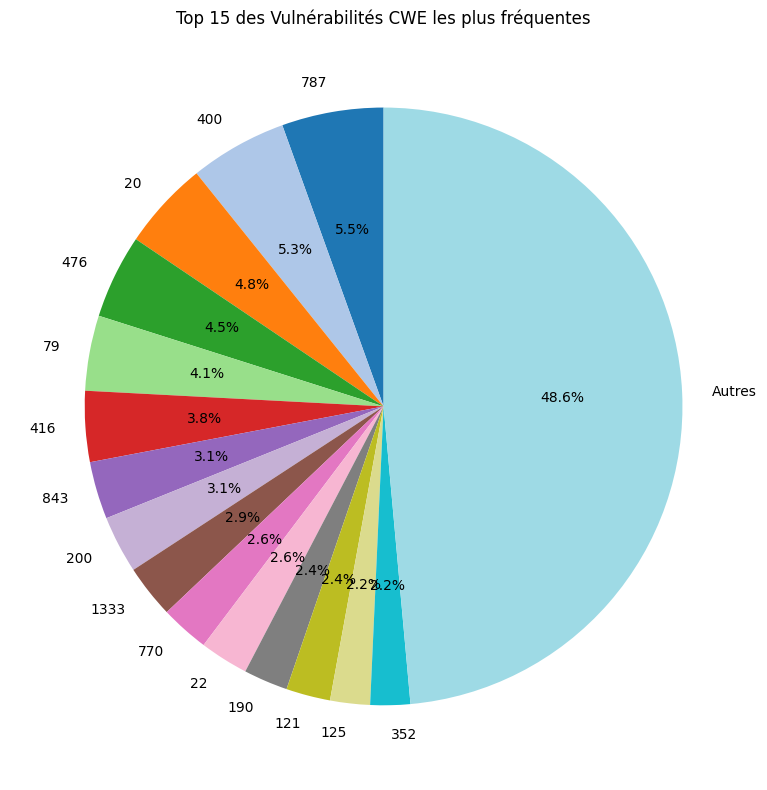

In [51]:
def plot_cwe_distribution():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(stats['cwe_counts'])))
    ax.pie(
        stats['cwe_counts'],
        labels=stats['cwe_counts'].index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    
    ax.set_title('Top 15 des Vulnérabilités CWE les plus fréquentes')
    plt.tight_layout()
    
    return fig
print(plot_cwe_distribution())

---

## 🎲 4. Analyse des Scores EPSS

*Étude de la probabilité d'exploitation des vulnérabilités*


Figure(1200x800)


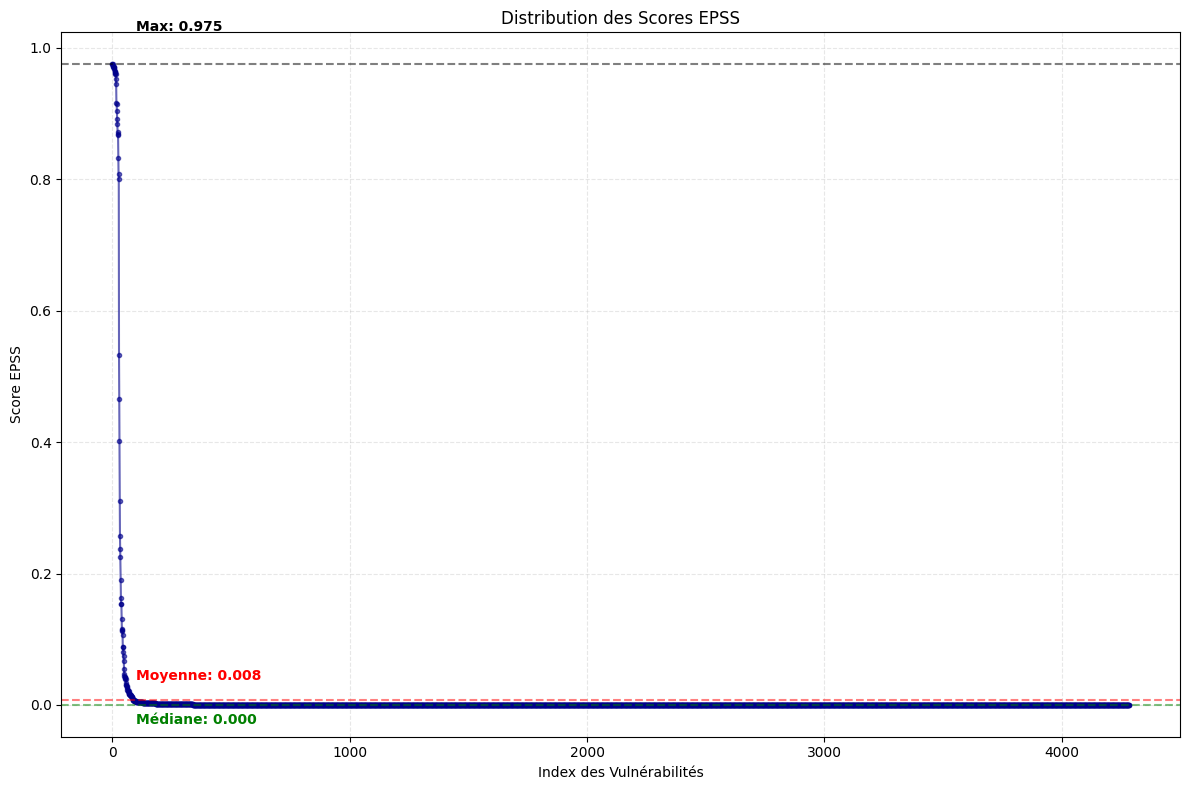

In [52]:
def plot_epss_distribution():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    epss_values = processed_data[processed_data['EPSS_Score'] != 'Non Dispo']['EPSS_Score'].sort_values(ascending=False)
    ax.plot(
        epss_values.values,
        marker='o',
        markersize=3,
        color='darkblue',
        alpha=0.6
    )
    
    colors = {'Max': 'black', 'Moyenne': 'red', 'Médiane': 'green'}
    y_offsets = {'Max': 0.05, 'Moyenne': 0.03, 'Médiane': -0.03}
    
    for stat_name, value in stats['epss_stats'].items():
        ax.axhline(y=value, color=colors[stat_name], linestyle='--', alpha=0.5)
        ax.annotate(
            f'{stat_name}: {value:.3f}',
            xy=(0, value),
            xytext=(100, value + y_offsets[stat_name]),
            color=colors[stat_name],
            fontweight='bold'
        )
    
    ax.set_title('Distribution des Scores EPSS')
    ax.set_xlabel('Index des Vulnérabilités')
    ax.set_ylabel('Score EPSS')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return fig
print(plot_epss_distribution())

---

## 🏢 5.  Éditeurs les Plus Touchés

*Analyse des éditeurs ayant le plus grand nombre de vulnérabilités signalées*


Figure(1200x800)


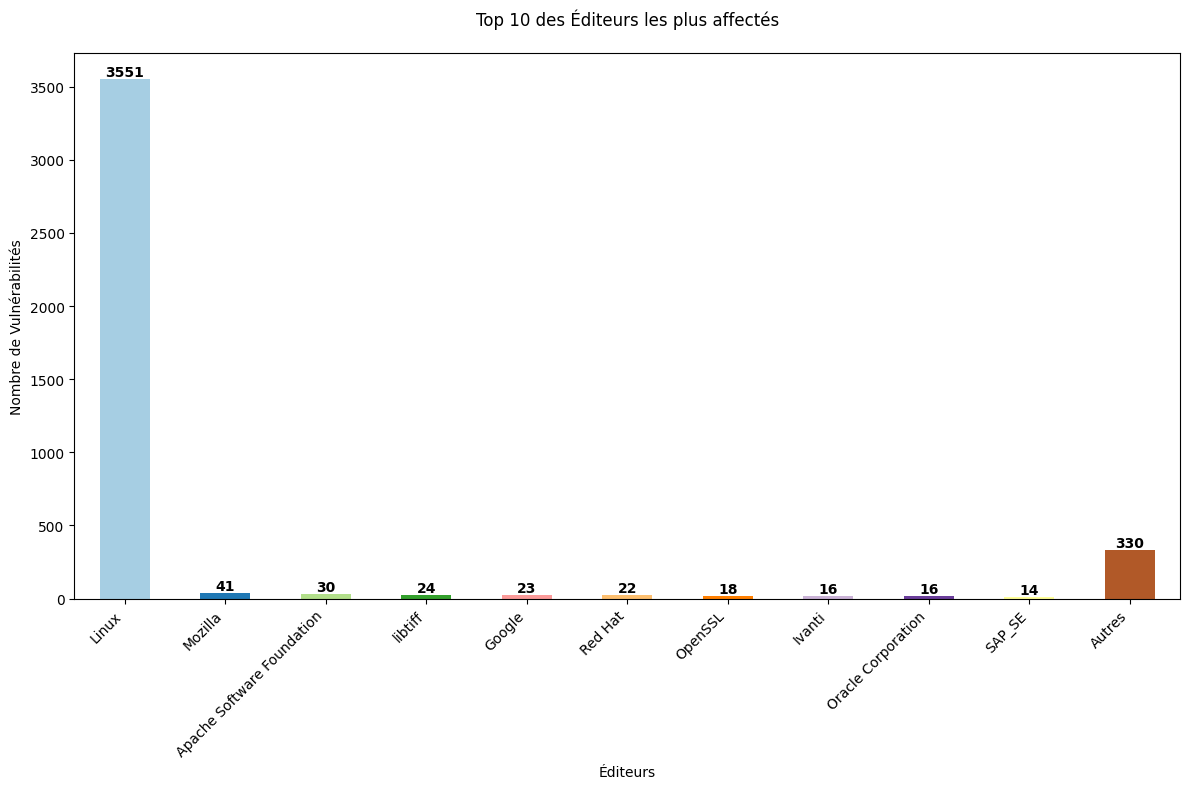

In [53]:
def plot_vendors_distribution():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    colors = plt.cm.Paired(np.linspace(0, 1, len(stats['vendors_counts'])))
    bars = stats['vendors_counts'].plot(kind='bar', color=colors, ax=ax)
    
    for bar in bars.patches:
        height = bar.get_height()
        ax.annotate(
            f'{int(height)}',
            xy=(bar.get_x() + bar.get_width()/2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
    
    ax.set_title('Top 10 des Éditeurs les plus affectés', pad=20, fontsize=12)
    ax.set_xlabel('Éditeurs')
    ax.set_ylabel('Nombre de Vulnérabilités')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return fig
print(plot_vendors_distribution())


---

## 🔍 6. Relation entre Sévérité et EPSS

*Analyse de la relation entre les scores de sévérité et les scores de probabilité d'exploitation EPSS*



Figure(1500x600)


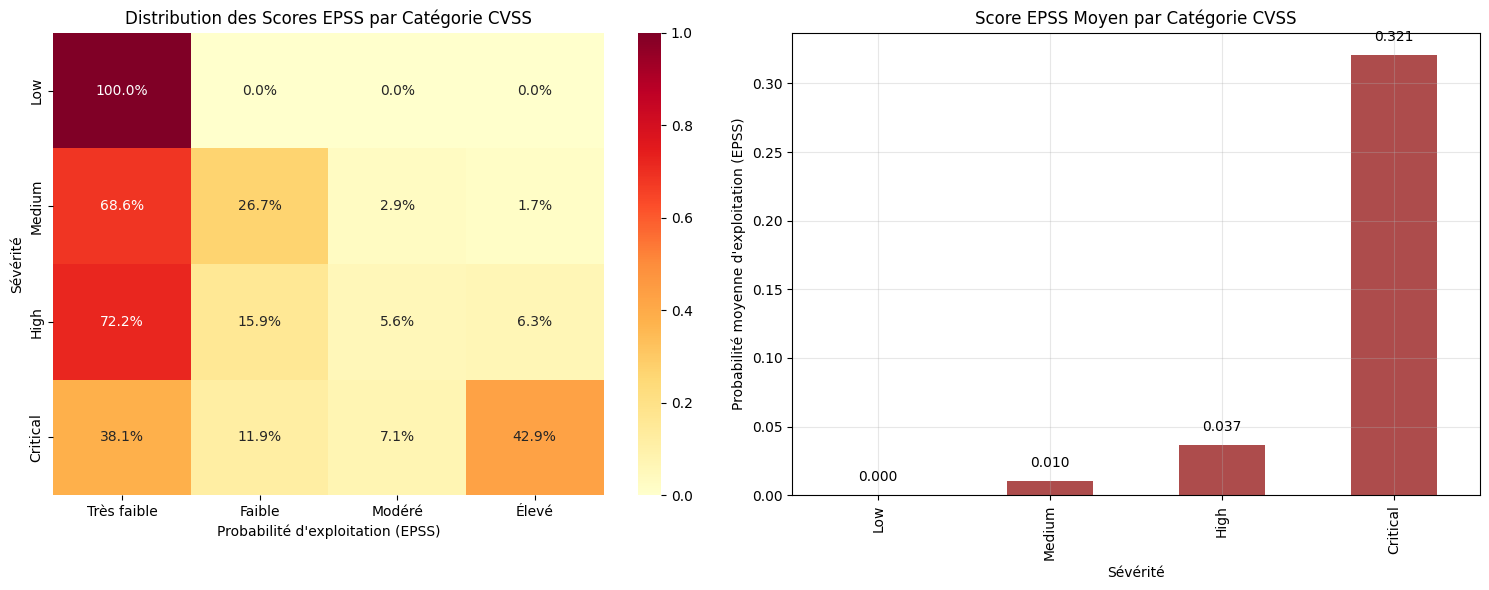

In [60]:
def plot_severite_epss_correlation():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.heatmap(
        stats['correlation']['contingency'],
        annot=True,
        fmt='.1%',
        cmap='YlOrRd',
        ax=ax1
    )
    ax1.set_title('Distribution des Scores EPSS par Catégorie CVSS')
    ax1.set_xlabel('Probabilité d\'exploitation (EPSS)')
    ax1.set_ylabel('Sévérité')
    
    stats['correlation']['means'].plot(kind='bar', ax=ax2, color='darkred', alpha=0.7)
    ax2.set_title('Score EPSS Moyen par Catégorie CVSS')
    ax2.set_xlabel('Sévérité')
    ax2.set_ylabel('Probabilité moyenne d\'exploitation (EPSS)')
    ax2.grid(True, alpha=0.3)
    
    for i, v in enumerate(stats['correlation']['means']):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    return fig
print(plot_severite_epss_correlation())

---

## 🔄 7. Corrélation CVSS-EPSS

*Analyse de la corrélation entre les CVSS et les scores de probabilité d'exploitation EPSS*

Figure(1200x800)


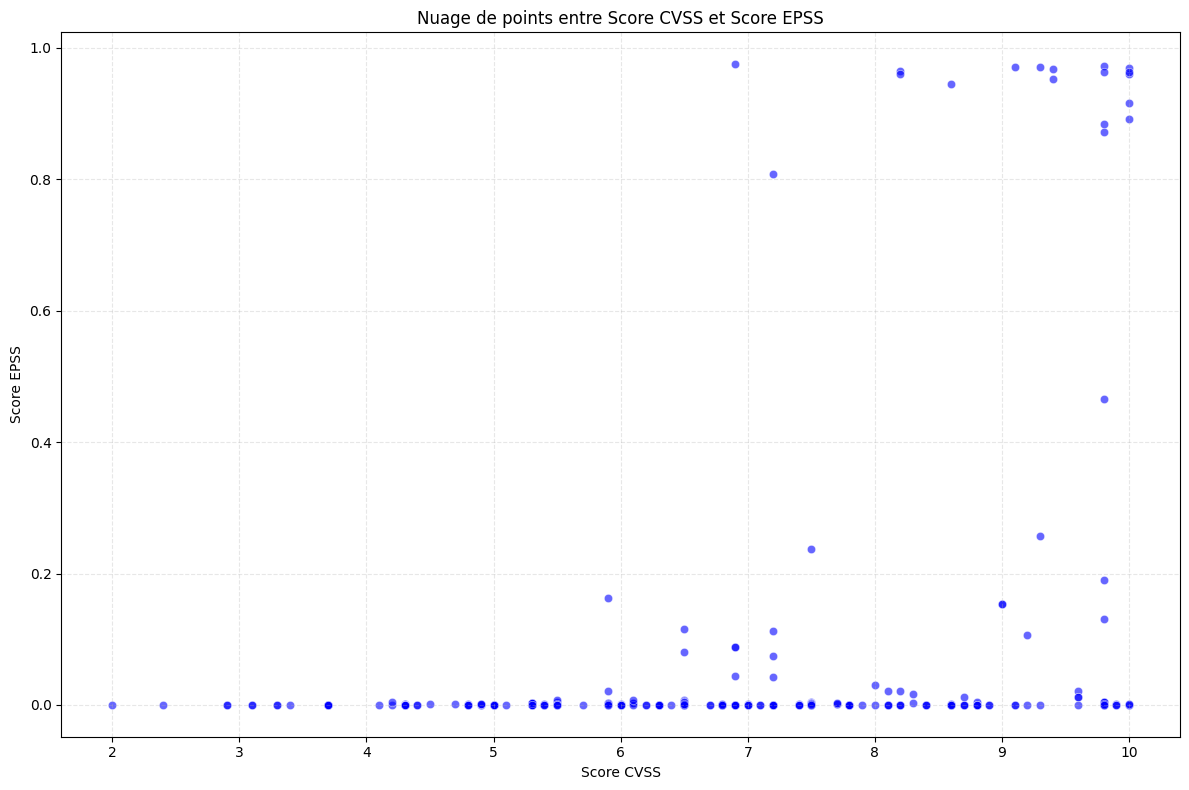

In [61]:
def plot_cvss_epss_scatter():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    mask_epss = processed_data['EPSS_Score'] != 'Non Dispo'
    ax.scatter(
        processed_data.loc[mask_epss, 'CVSS_Score'],
        processed_data.loc[mask_epss, 'EPSS_Score'],
        alpha=0.6,
        edgecolors='w',
        linewidth=0.5,
        color='blue'
    )
    
    ax.set_title('Nuage de points entre Score CVSS et Score EPSS')
    ax.set_xlabel('Score CVSS')
    ax.set_ylabel('Score EPSS')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig
print(plot_cvss_epss_scatter())

---

## ⏱️8. Dispersion des CVSS dans le Temps

*Évolution des vulnérabilités dans le temps*

Figure(1200x800)


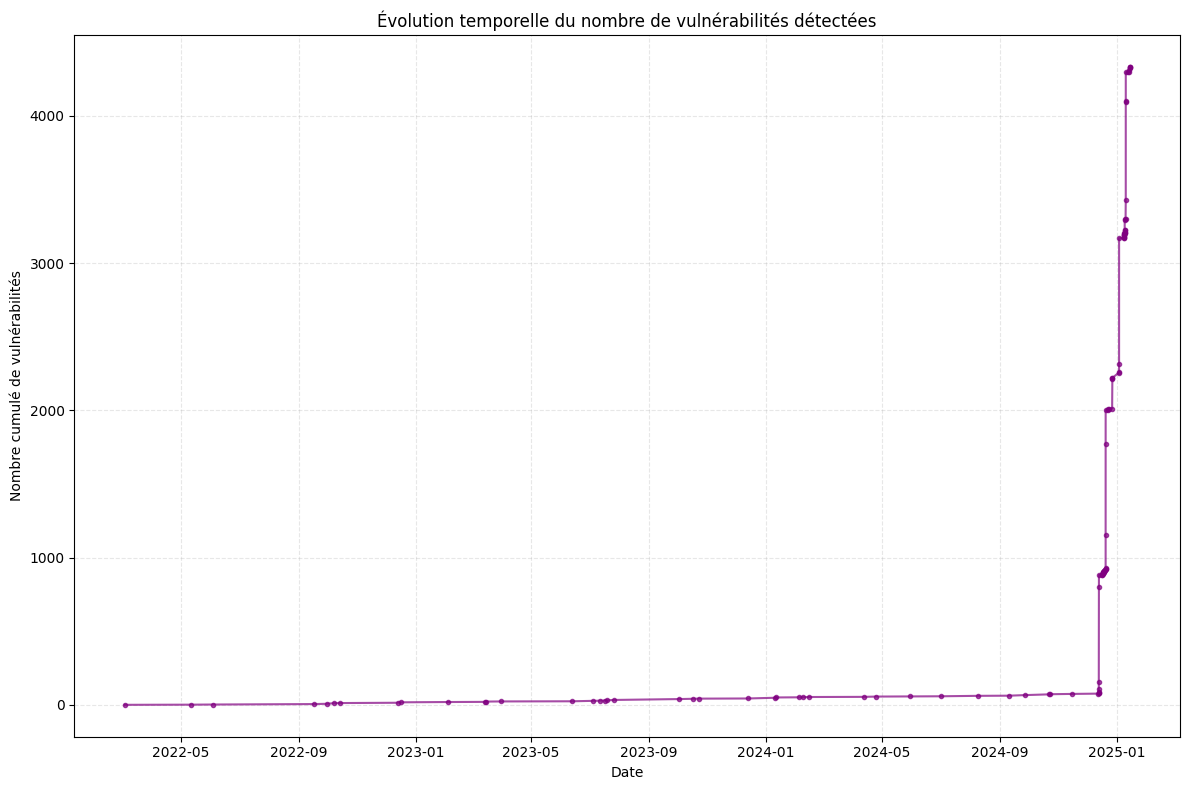

In [62]:
def plot_vulnerability_evolution():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    ax.plot(
        stats['date_cumsum'].index,
        stats['date_cumsum'].values,
        marker='o',
        markersize=3,
        color='purple',
        alpha=0.7
    )
    
    ax.set_title('Évolution temporelle du nombre de vulnérabilités détectées')
    ax.set_xlabel('Date')
    ax.set_ylabel('Nombre cumulé de vulnérabilités')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig
print(plot_vulnerability_evolution())


---

## 📊 9. Dispersion des Scores CVSS par Éditeur

*Analyse de la répartition des scores CVSS pour les éditeurs les plus touchés*


Figure(1200x800)


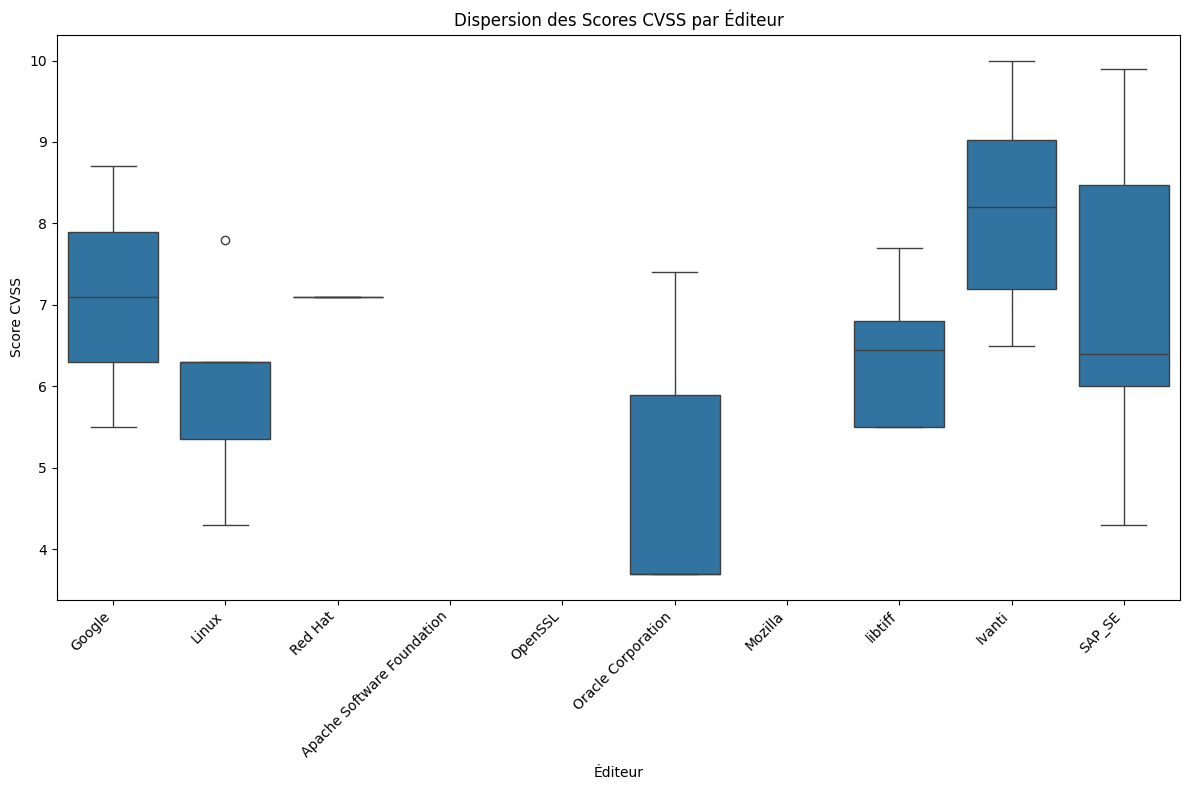

In [63]:
def plot_cvss_by_editor_box():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    sns.boxplot(
        data=stats['boxplot_data'],
        x='Éditeur',
        y='CVSS_Score',
        ax=ax
    )
    
    ax.set_title('Dispersion des Scores CVSS par Éditeur')
    ax.set_xlabel('Éditeur')
    ax.set_ylabel('Score CVSS')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    return fig
print(plot_cvss_by_editor_box())

---

## 📊 10. Dispersion des CVSS par version de produit

*Distribution des vulnérabilités par version de produit*

Figure(1200x800)


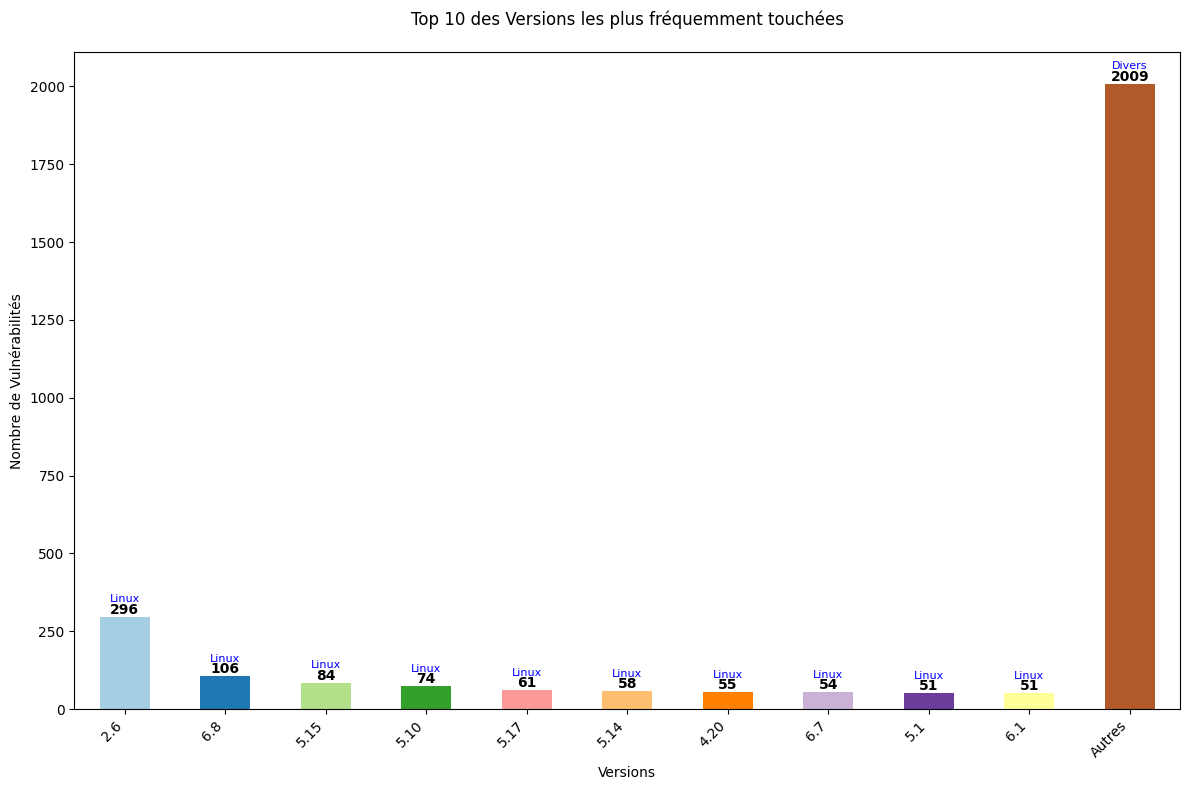

In [ ]:
def plot_versions_distribution():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    colors = plt.cm.Paired(np.linspace(0, 1, len(stats['versions']['counts'])))
    bars = stats['versions']['counts'].plot(kind='bar', color=colors, ax=ax)
    
    for bar in bars.patches:
        ax.annotate(
            f'{int(bar.get_height())}',
            xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
    
    for i, version in enumerate(stats['versions']['counts'].index):
        product_name = stats['versions']['products'].get(version, 'Unknown')
        ax.annotate(
            product_name,
            xy=(bars.patches[i].get_x() + bars.patches[i].get_width()/2,
                bars.patches[i].get_height() + 40),
            ha='center',
            va='bottom',
            fontsize=8,
            color='blue'
        )
    
    ax.set_title('Top 10 des Versions les plus fréquemment touchées', pad=20, fontsize=12)
    ax.set_xlabel('Versions')
    ax.set_ylabel('Nombre de Vulnérabilités')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return fig
print(plot_versions_distribution())

---

## 📋 11. Analyse par Type de Bulletin

*Étude des vulnérabilités classées par type de bulletin de sécurité pour les éditeurs les plus touchés*


Figure(1200x800)


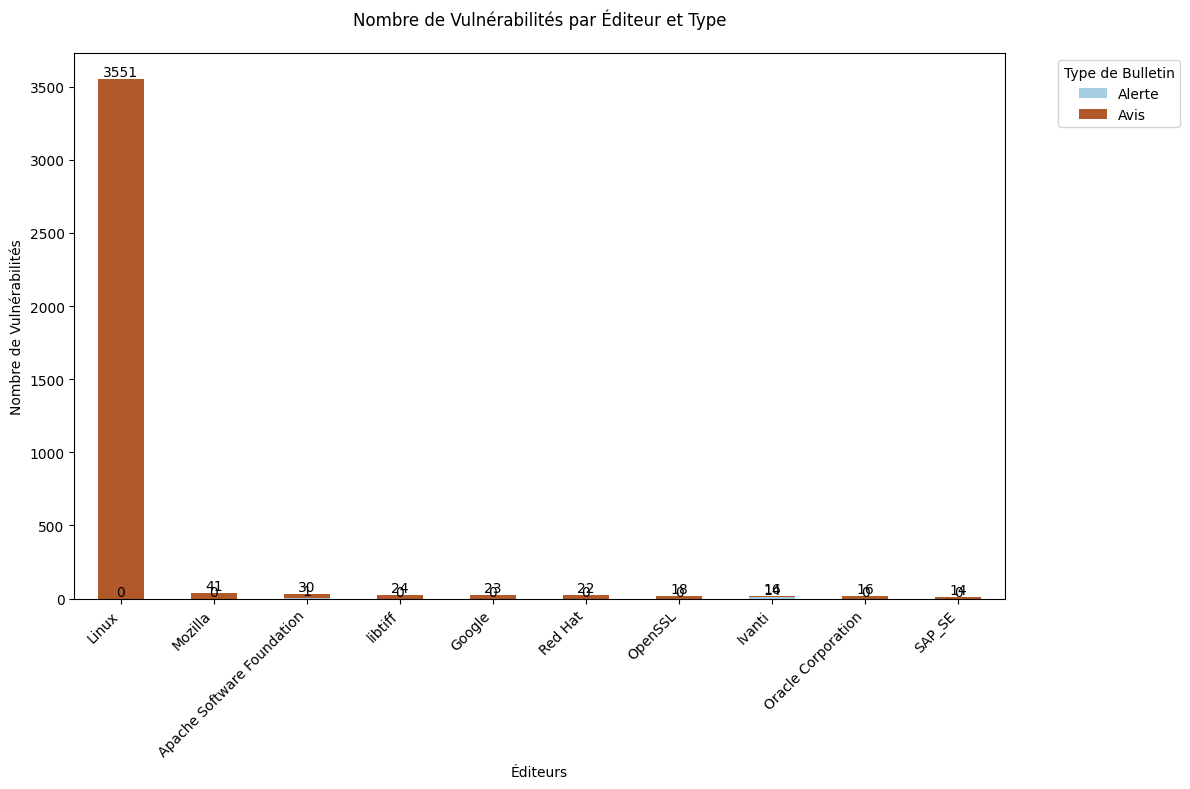

In [58]:
def plot_bulletin_distribution():
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    colors = plt.cm.Paired(np.linspace(0, 1, len(stats['bulletin_data'].columns)))
    stats['bulletin_data'].plot(kind='bar', stacked=True, color=colors, ax=ax)
    
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    
    ax.set_title('Nombre de Vulnérabilités par Éditeur et Type', pad=20, fontsize=12)
    ax.set_xlabel('Éditeurs')
    ax.set_ylabel('Nombre de Vulnérabilités')
    plt.xticks(rotation=45, ha='right')
    ax.legend(title='Type de Bulletin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return fig
print(plot_bulletin_distribution())

---

## 🔍 12. Focus sur le CWE Principal

*Analyse approfondie du type de vulnérabilité le plus fréquent*

(<Figure size 1200x800 with 1 Axes>, <Figure size 1200x800 with 1 Axes>)


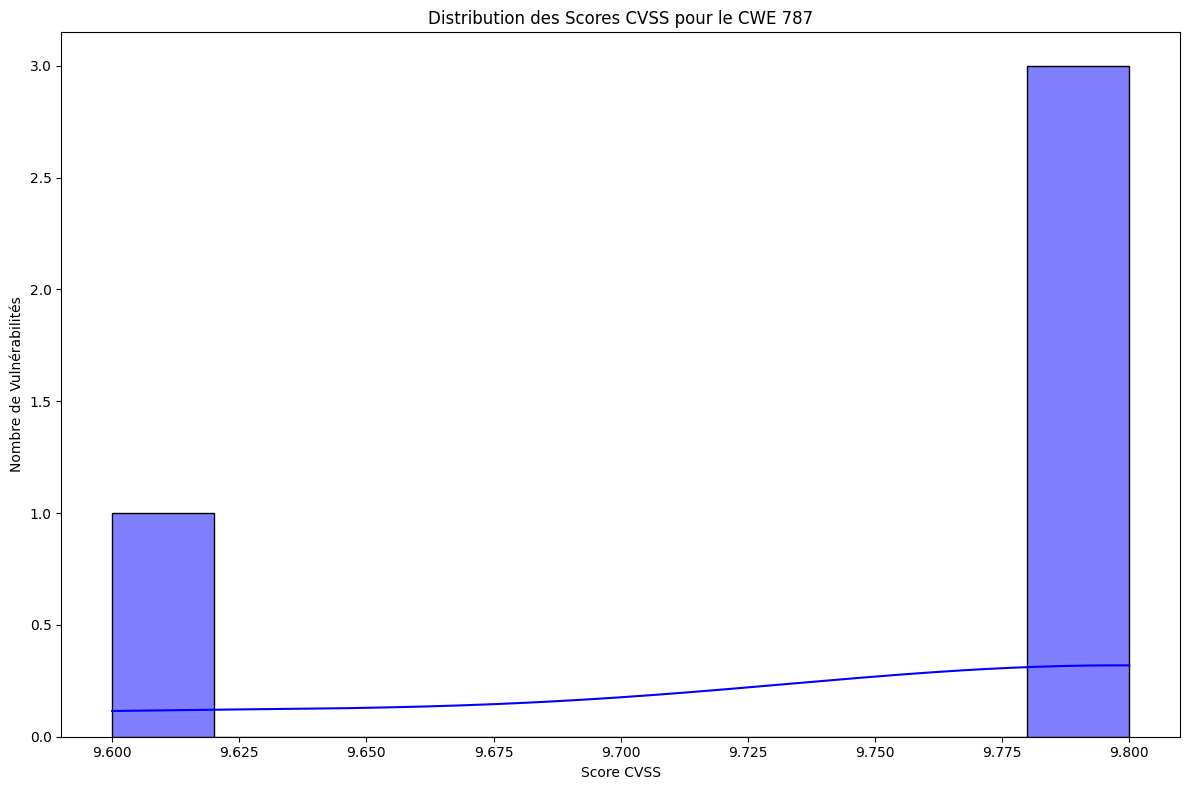

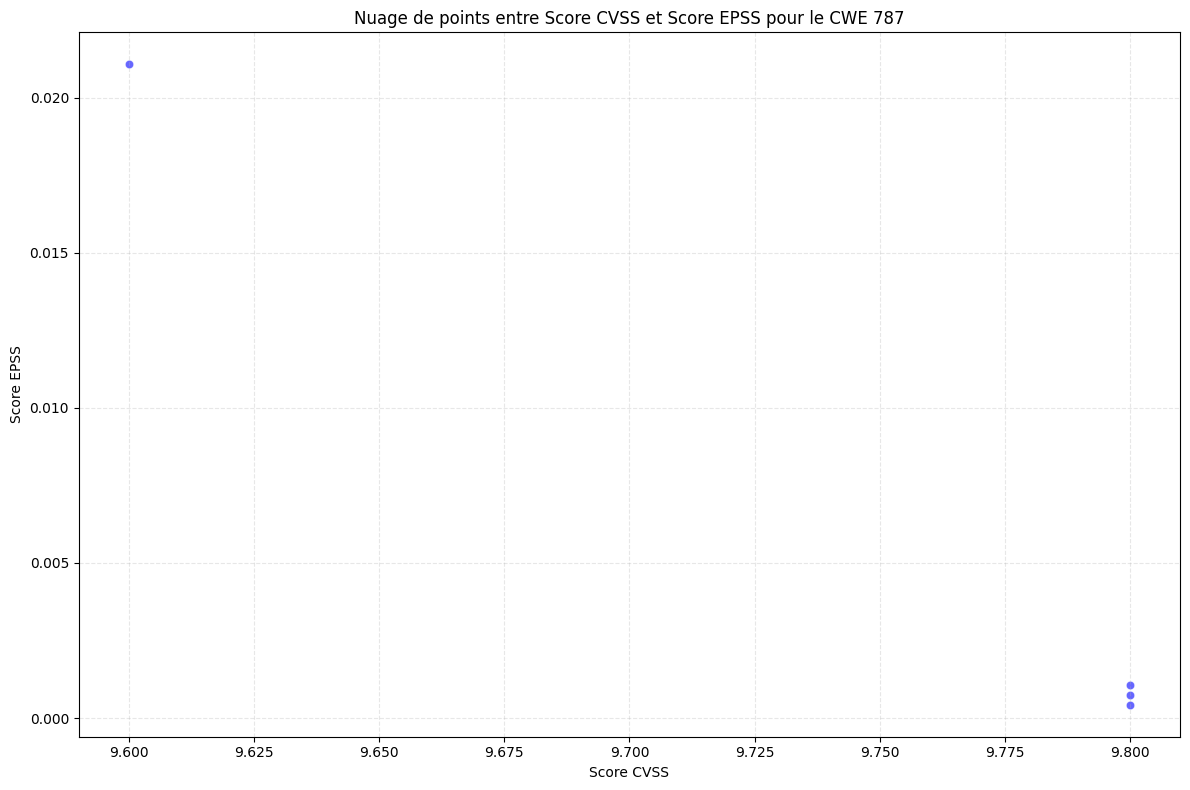

In [46]:
def plot_common_cwe_analysis():
    most_common_cwe = stats['cwe_counts'].index[0]
    cwe_data = processed_data[processed_data['CWE'].str.contains(most_common_cwe, na=False)]
    
    fig1, ax1 = plt.subplots(figsize=FIGURE_SIZE)
    sns.histplot(
        data=cwe_data['CVSS_Score'].dropna(),
        bins=10,
        kde=True,
        color='blue',
        ax=ax1
    )
    ax1.set_title(f'Distribution des Scores CVSS pour le CWE {most_common_cwe}')
    ax1.set_xlabel('Score CVSS')
    ax1.set_ylabel('Nombre de Vulnérabilités')
    plt.tight_layout()

    fig2, ax2 = plt.subplots(figsize=FIGURE_SIZE)
    mask_epss = cwe_data['EPSS_Score'] != 'Non Dispo'
    ax2.scatter(
        cwe_data.loc[mask_epss, 'CVSS_Score'],
        cwe_data.loc[mask_epss, 'EPSS_Score'].astype(float),
        alpha=0.6,
        edgecolors='w',
        linewidth=0.5,
        color='blue'
    )
    ax2.set_title(f'Nuage de points entre Score CVSS et Score EPSS pour le CWE {most_common_cwe}')
    ax2.set_xlabel('Score CVSS')
    ax2.set_ylabel('Score EPSS')
    ax2.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return fig1, fig2
print(plot_common_cwe_analysis())